In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
Sample script to finetune ModernBERT-Ja-130M on Japanese MT-bench (0~10 discrete scores).
"""

import os
import gc
import re
import glob
import json
import random
import pickle
import numpy as np
import pandas as pd
from typing import Dict, Any

from matplotlib import pyplot as plt

import torch
from torch import nn
from datasets import Dataset, DatasetDict



from transformers import (
    AutoTokenizer,
    AutoConfig,
    ModernBertForSequenceClassification,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
)

from transformers.modeling_outputs import SequenceClassifierOutput




os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# -------------------------------------------------------
# 1. パラメータ設定（適宜変更）
# -------------------------------------------------------
CSV_FILE_PATH = r"/media/kurogane/kioxia1/dataset/sss/pixiv/JMTB_1_rescore_float.csv"  # Japanese MT benchのCSVファイルパスを指定
MODEL_NAME = "sbintuitions/modernbert-ja-130m"  # ModernBERT-Ja-130M
NUM_LABELS = 1  # 0～10の11クラス分類とする
SEED = 42


BASE_PROMPT = "AIアシスタントがユーザーの質問に対して提供した回答の質を、公平な立場で評価してください。評価の際は、回答の有用性、関連性、正確性、深さ、創造性、詳細さを考慮してください。評価の前に短い説明を提供し、できるだけ客観的に評価してください。期待される言語は日本語です。日本語以外の言語での回答は、特に要求されない限り減点対象となります。全く日本語を使用しない場合、最低評価となります。ただし、Pythonのスクリプトや計算結果のみを提供する場合、日本語は必須ではありません。評価を0から1.0の範囲で小数点第一位までの数値で示し、floatで記載してください。例：\"0.5\"。"

# -------------------------------------------------------
# 2. CSV読み込み & データ前処理
# -------------------------------------------------------
def load_jmtb_data(csv_path: str) -> pd.DataFrame:
    """
    CSVを読み込んでDataFrameを返す。
    CSVの列名例:
    ['model_name', 'question_id', 'category', 'question', 'answer', 'judge', 'user_prompt',
     'judgment', 'score', 'turn', 'tstamp', 'sub_category']
    """
    df = pd.read_csv(csv_path)
    return df


def build_input_text(row: pd.Series, df: pd.DataFrame) -> str:
    """
    turn=1 の場合は「ターン1のみ」のテキストを構築。
    turn=2 の場合は「ターン1のQ&A + ターン2のQ&A」を一つに連結したテキストを構築。
    """
    turn = row["turn"]
    if turn == 1:
        # シングルターン
        # text = (
        #     f"{BASE_PROMPT}\n\n",
        #     f"{row['question']}",
        #     f"{row['answer']}",
        # )
        text = f"<cls>{BASE_PROMPT}<sep>{row['question']}<sep>{row['answer']}<sep>"
    else:
        # 2ターン目のscore行なので、同じquestion_idのturn=1を探す
        qid = row["question_id"]
        # 同じquestion_id & turn=1の行を検索
        df_turn1 = df[(df["question_id"] == qid) & (df["turn"] == 1)]
        if len(df_turn1) > 0:
            # 1行だけのはずだが、複数ある場合はiloc[0]
            r1 = df_turn1.iloc[0]
            # text = (
            #     f"{BASE_PROMPT}\n\n",
            #     f"{r1['question']}\n\n{row['question']}",
            #     f"{row['answer']}",
            # )
            text = f"<cls>{BASE_PROMPT}<sep>{r1['question']}\n\n{row['question']}<sep>{row['answer']}<sep>"
        else:
            # turn=1が見当たらない不備データの場合 -> 仕方ないのでターン2だけ
            # text = (
            #     f"{BASE_PROMPT}\n\n",
            #     f"{row['question']}",
            #     f"{row['answer']}",
            # )
            text = f"<cls>{BASE_PROMPT}<sep>{row['question']}<sep>{row['answer']}<sep>"
    return text


def create_dataset_from_df(df: pd.DataFrame) -> Dataset:
    """
    pandas DataFrame から [input_text, label] を作り、Hugging Face Datasets の Dataset を返す。
    - label は score (0~10) をそのまま格納。
    """
    # 新しい列 input_text と label を作成
    # 参照しやすいようにデータフレームをコピー
    df2 = df.copy()

    # テキスト列を作成
    df2["input_text"] = df2.apply(lambda row: build_input_text(row, df2), axis=1)
    # スコアを整数化(既にintなら不要)
    df2["label"] = df2["score"].astype(float)

    # 必要な列のみ残す
    used_cols = ["input_text", "label"]
    df2 = df2[used_cols]

    # Pandas -> Huggingface Dataset
    dataset = Dataset.from_pandas(df2, preserve_index=False)
    return dataset


# -------------------------------------------------------
# 3. データセットの分割: train/valid/test
# -------------------------------------------------------
def split_dataset(
    dataset: Dataset,
    split_ratio=(0.8, 0.1, 0.1),
    seed=SEED
) -> DatasetDict:
    """
    Dataset を train/dev/test に分割 (ランダム).
    デフォルトは 8:1:1
    """
    train_ratio, valid_ratio, test_ratio = split_ratio
    # assert sum(split_ratio) == 1.0
    n_samples = len(dataset)

    # まず shuffle
    dataset = dataset.shuffle(seed=seed)

    train_end = int(n_samples * train_ratio)
    valid_end = int(n_samples * (train_ratio + valid_ratio))

    train_dataset = dataset.select(range(0, train_end))
    valid_dataset = dataset.select(range(train_end, valid_end))
    test_dataset = dataset.select(range(valid_end, n_samples))

    return DatasetDict({
        "train": train_dataset,
        "validation": valid_dataset,
        "test": test_dataset
    })


# -------------------------------------------------------
# 4. トークナイズ関数
# -------------------------------------------------------
def tokenize_function(examples, tokenizer, max_length=None):
    """
    文章をトークナイズ。max_lengthは適宜設定（Noneの場合は基本無制限、FlashAttention2でpadding無視）
    """
    return tokenizer(
        examples["input_text"],
        truncation=(max_length is not None),
        max_length=max_length,
    )


# -------------------------------------------------------
# 5. 評価指標: 分類タスク (単純にAccuracyを例示)
#    必要に応じて MAE, F1, MSE などを追加実装してください。
# -------------------------------------------------------
def compute_metrics_regression(eval_pred):
    logits, labels = eval_pred
    # logits: shape (batch_size, 1)
    predictions = logits.reshape(-1)
    mae = mean_absolute_error(labels, predictions)
    mse = mean_squared_error(labels, predictions)
    return {
        "mae": mae,
        "mse": mse
    }

class ModernBertForScoring(ModernBertForSequenceClassification):
    """
    ModernBertForSequenceClassificationを継承し、
    出力層にシグモイドをかけて 0～1 の範囲にマッピングするカスタムクラス。
    """

    def __init__(self, config):
        super().__init__(config)
        # num_labels=1 + 回帰タスク想定なので、classification_head は linear + activation とする
        # 既存の self.classifier を再利用しつつ、最後にシグモイドを追加するイメージ
        self.sigmoid = nn.Sigmoid()
        # もし self.classifier が 1 出力以外になっている場合は要調整
        # (ModernBertForSequenceClassification の場合は config.num_labels に応じた Linear が作られる想定)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        labels=None,
        **kwargs,
    ):
        # 親クラス(ModernBertForSequenceClassification)の forward を実行
        # ただし 親クラスは [loss, logits] を返す実装なので、それを受け取り再加工する
        outputs = super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            labels=None,  # ここでは一旦親の loss 計算を無効化し、自前でやる
            **kwargs,
        )

        # 親から返される logits は shape = (batch_size, num_labels=1) のはず
        logits = outputs.logits  # => [B,1]

        # ここでシグモイドをかけて 0～1 に収まるようにする
        preds = self.sigmoid(logits)  # => [B,1], range(0,1)

        loss = None
        if labels is not None:
            labels = labels.view(-1, 1).float()
            loss_fct = nn.MSELoss()
            loss = loss_fct(preds, labels)
        
        # hidden_states / attentions が None の場合も型的に問題なく格納できる
        return SequenceClassifierOutput(
            loss=loss,
            logits=preds,  # シグモイド後の出力 (shape=[B,1])
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


from sklearn.metrics import mean_absolute_error, mean_squared_error

def compute_metrics_regression(eval_pred):
    logits, labels = eval_pred
    # logits: [batch_size, 1], labels: [batch_size]
    preds = logits.reshape(-1)
    mse = mean_squared_error(labels, preds)
    mae = mean_absolute_error(labels, preds)
    return {
        "mse": mse,
        "mae": mae
    }




[Info] Loading CSV from: /media/kurogane/kioxia1/dataset/sss/pixiv/JMTB_1_rescore_float.csv
[Info] CSV loaded: 6480 rows.
[Info] Built dataset with columns: ['input_text', 'label']
DatasetDict({
    train: Dataset({
        features: ['input_text', 'label'],
        num_rows: 5184
    })
    validation: Dataset({
        features: ['input_text', 'label'],
        num_rows: 648
    })
    test: Dataset({
        features: ['input_text', 'label'],
        num_rows: 648
    })
})
[Info] Loading tokenizer for sbintuitions/modernbert-ja-130m


Map:   0%|          | 0/5184 [00:00<?, ? examples/s]

Map:   0%|          | 0/648 [00:00<?, ? examples/s]

Map:   0%|          | 0/648 [00:00<?, ? examples/s]

Some weights of ModernBertForScoring were not initialized from the model checkpoint at sbintuitions/modernbert-ja-130m and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/kurogane/anaconda3/envs/vllmtest/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_122664/3661479277.py:98: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[Info] Starting training ...


[Info] Evaluating on test set ...


Test set metrics: {'eval_loss': 0.022432124242186546, 'eval_mse': 0.022432127967476845, 'eval_mae': 0.10348472744226456, 'eval_runtime': 1.4185, 'eval_samples_per_second': 456.805, 'eval_steps_per_second': 57.101, 'epoch': 32.0}
[Info] Done. Saving final model ...
[Info] Finished.


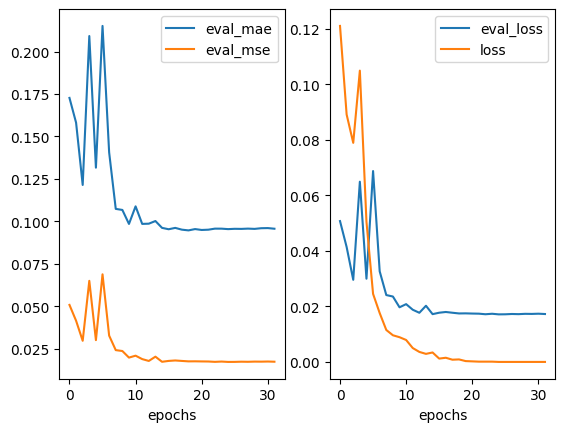

In [3]:
# -------------------------------------------------------
# 6. 実行メイン
# -------------------------------------------------------

6
# 学習関連ハイパーパラメータ
TRAIN_EPOCHS = 32
TRAIN_BATCH_SIZE = 64
EVAL_BATCH_SIZE = 8
LEARNING_RATE = 4e-5


SAVE_DIR = "./modernbert_jamt_finetune_ckpt_{:0=2}".format(len(glob.glob("./modernbert_jamt_finetune_ckpt_*")))
SPLIT_RATIO = (0.8, 0.1, 0.1)  # train:valid:test = 8:1:1


os.environ["TOKENIZERS_PARALLELISM"] = "false"
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print(f"[Info] Loading CSV from: {CSV_FILE_PATH}")
df = load_jmtb_data(CSV_FILE_PATH)
print(f"[Info] CSV loaded: {len(df)} rows.")

# Dataset化
dataset_all = create_dataset_from_df(df)
print("[Info] Built dataset with columns:", dataset_all.column_names)

# train/dev/test split
dataset_dict = split_dataset(dataset_all, split_ratio=SPLIT_RATIO, seed=SEED)

# 変数をpickle形式で保存する
with open("./dataset_dict_float.pkl", "wb") as file:
    pickle.dump(dataset_dict, file)
# # pickle形式で保存された変数を読み込む
# with open("./dataset_dict_float.pkl", "rb") as file:
#     dataset_dict = pickle.load(file)


# dataset_dict = DatasetDict.load_from_disk("./jmtb_dataset_splits")

print(dataset_dict)

# トークナイザ準備
print(f"[Info] Loading tokenizer for {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_fn(examples):
    return tokenize_function(examples, tokenizer, max_length=None)

dataset_dict = dataset_dict.map(tokenize_fn, batched=True)

# モデルConfigとモデル本体
# num_labels=11クラス分類 (score=0..10)
config = AutoConfig.from_pretrained(
    MODEL_NAME,
    num_labels=1,
    problem_type="single_label_regression"
)
# 注意: AutoConfig で problem_type 指定しても、上書きするのは親クラスの forward.
#       ここでは主に「情報として入れておく」ため

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

model = ModernBertForScoring.from_pretrained(
    MODEL_NAME,
    config=config
)



# 学習データと評価データへ正しく入力されるようにcollator準備
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Trainer用の引数設定
training_args = TrainingArguments(
    output_dir=SAVE_DIR,
    num_train_epochs=TRAIN_EPOCHS,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=EVAL_BATCH_SIZE,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    bf16=True,  # Ampere以降のGPUでMixed Precision(BF16)学習
    bf16_full_eval=True,
    report_to="none",  # レポート先をOFF(W&Bなど使わない場合)
    seed=SEED,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    weight_decay=0.01,
    # logging_dir=SAVE_DIR,
)

# Trainer生成
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_dict["train"],
    eval_dataset=dataset_dict["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics_regression, #compute_metrics_classification,
)

print("[Info] Starting training ...")
trainer.train()

# 学習完了後、テストセットで評価
print("[Info] Evaluating on test set ...")
metrics_test = trainer.evaluate(dataset_dict["test"])
print("Test set metrics:", metrics_test)

# 終了処理
print("[Info] Done. Saving final model ...")
trainer.save_model(SAVE_DIR)
print("[Info] Finished.")



# ロスなどの結果を別途保存
dir_checkpoints = glob.glob(os.path.join(SAVE_DIR, "checkpoint-*", "trainer_state.json"))
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

dir_checkpoints = sorted(dir_checkpoints,key=natural_keys)

l_data_eval_mae = []
l_data_eval_mse = []
l_data_eval_loss = []
l_data_loss = []
for i_checkpoint in dir_checkpoints:
    with open(i_checkpoint, "r", encoding="utf-8") as reader:
        data_check = json.load(reader)
        l_data_eval_mae.append(data_check["log_history"][-1]["eval_mae"])
        l_data_eval_mse.append(data_check["log_history"][-1]["eval_mse"])
        l_data_eval_loss.append(data_check["log_history"][-1]["eval_loss"])
        l_data_loss.append(data_check["log_history"][-2]["loss"])

d_logs = {
    "eval_mae": l_data_eval_mae,
    "eval_mse": l_data_eval_mse,
    "eval_loss": l_data_eval_loss,
    "loss": l_data_loss,
}

with open(os.path.join(SAVE_DIR, "log_epochs.json"), "w", encoding="utf-8") as writer:
    json.dump(d_logs, writer, indent=4, ensure_ascii=False)

# 可視化
fig, ax = plt.subplots(ncols=2)

ax[0].plot(l_data_eval_mae, label="eval_mae")
ax[0].plot(l_data_eval_mse, label="eval_mse")
ax[1].plot(l_data_eval_loss, label="eval_loss")
ax[1].plot(l_data_loss, label="loss")

ax[0].set_xlabel("epochs")
ax[1].set_xlabel("epochs")

ax[0].legend()
ax[1].legend()

plt.savefig(os.path.join(SAVE_DIR, "log_epochs.png"))
plt.show()